# Example: "Lotka-Volterra" Equations

## Scope

This notebook introduces the **input format** of [yaml2sbml](https://github.com/yaml2sbml-dev/yaml2sbml) and showcases the **Python interface** of the tool. Furthermore, this notebook demonstrates the **simulation** of an SBML model using [AMICI](https://github.com/AMICI-dev/AMICI) and  **parameter estimation** from PEtab using [pyPESTO](https://github.com/ICB-DCM/pyPESTO).

## Equations

The "Lotka-Volterra" Equations are given by 

\begin{align*}
\frac{d}{dt} x_1 &= \alpha x_1 - \beta x_1x_2, \\
\frac{d}{dt} x_2 &= \delta x_1x_2 - \gamma x_2.
\end{align*}
Here $x_1$ denotes the number of a prey and $x_2$ the number of a predator species and $\alpha, \beta, \gamma, \delta$ are positive parameters describing the birth/death and interactions of the two species.

## YAML file for model simulation in SBML: 

The **states** $x_1$ and $x_2$, as well as their initial values and dynamics are defined in the `odes:` section:

```yaml
odes:
    - stateId: x_1
      rightHandSide: alpha * x_1 - beta * x_1 * x_2
      initialValue: 2

    - stateId: x_2
      rightHandSide: delta * x_1 * x_2 - gamma * x_2
      initialValue: 2
```

Furthermore, the **parameters** together with their values are defined in the `parameters:` section:

```yaml
parameters: 
    - parameterId: alpha
      nominalValue: 2
  
    - parameterId: beta
      nominalValue: 4
     
   ...
```

The full file is given in `Lotka_Volterra_basic.yml`.

## Format validation of the YAML model:

The YAML model can be validated by the `yaml2sbml` package via:

In [1]:
import yaml2sbml

yaml_file_basic = 'Lotka_Volterra_basic.yml'
yaml2sbml.validate_yaml(yaml_dir=yaml_file_basic)

YAML file is valid ✅


## Conversion to SBML for model simulation:

We now want to convert the YAML file into a SBML file. Within Python this is possible via:

In [2]:
import yaml2sbml

sbml_output_file = 'Lotka_Volterra_basic.xml'
yaml2sbml.yaml2sbml(yaml_file_basic, sbml_output_file)

We will now use the SBML simulator [AMICI](https://github.com/AMICI-dev/AMICI) to simulate the ODEs. First `AMICI` generates the models' `C++` code.

In [3]:
%%capture

import amici
import amici.plotting

model_name = 'Lotka_Volterra'
model_output_dir = 'Lotka_Volterra_AMICI'

sbml_importer = amici.SbmlImporter(sbml_output_file)
sbml_importer.sbml2amici(model_name,
                         model_output_dir)

Then we can reload and simulate the compiled model.

In [4]:
%%capture

import os
import sys
import importlib
import numpy as np

# import model
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)

# create model + solver instance
model = model_module.getModel()
solver = model.getSolver()

# Define time points and run simulation using default model parameters/solver options
model.setTimepoints(np.linspace(0, 20, 201)) 
rdata = amici.runAmiciSimulation(model, solver)

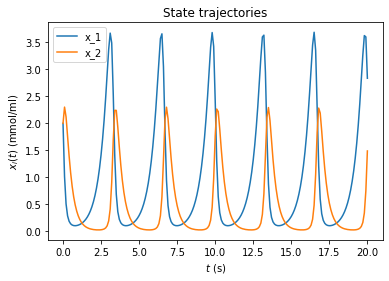

In [5]:
# plot trajectories
amici.plotting.plotStateTrajectories(rdata, model=model)

## Conversion to PEtab for parameter fitting:

In order to obtain valid [PEtab](https://github.com/PEtab-dev/PEtab) tables, we need to extend the `.yml` file. The extended `.yml` file is given as `Lotka_Volterra_PEtab.yml`.


#### Parameters:
The `parameters:` section can be extended to store parameter bounds, transformations, ... This information is written to the PEtab _parameter table_.
```yml
parameters: 
    - parameterId: alpha
      nominalValue: 2
      parameterScale: log10
      lowerBound: 0.01
      upperBound: 100
      estimate: 1
     
   ...
```

(**Note:** PEtab measurement tables are outside of the scope of `yaml2sbml`. Hence a predefined measurement table for this example is given under `./Lotka_Volterra_PEtab/measurement_table.tsv`.)

#### Observables:
The `observables:` section allows to specify the mapping of system state to measurement and the measurement noise. This information is written in the PEtab _observable table_. 

```yml
observables:
    - observableId: prey_measured
      observableFormula: log10(x_1)
      observableTransformation: lin
      noiseFormula: 1
      noiseDistribution: normal
```

#### Conditions:
The `conditions:` section allows to specify different experimental setups. This information is written in the PEtab _condition table_. This example only defines the trivial condition table, consisting of only one experimental setup.

```yml
conditions:
    - conditionId: condition1
```

### yaml2petab:

We want to create the corresponding PEtab tables for the model in `Lotka_Volterra_PEtab.yml`. Since the definition of PEtab measurement tables is outside of the scope of `yaml2sbml`, a predefined measurement table is given under `./Lotka_Volterra_PEtab/measurement_table.tsv`.  

In [6]:
yaml_file_petab = 'Lotka_Volterra_PEtab.yml'
PEtab_dir = './Lotka_Volterra_PEtab/'
PEtab_yaml_name = 'problem.yml'
measurement_table_name = 'measurement_table.tsv'
model_name = 'Lotka_Volterra_with_observables'

yaml2sbml.yaml2petab(yaml_file_petab,
                     PEtab_dir, 
                     model_name, 
                     PEtab_yaml_name, 
                     measurement_table_name)

`yaml2petab` created the PEtab files. In the following we show how to import and fit a PEtab problem in pyPESTO. 

In [7]:
%%capture
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.visualize as visualize

# import PEtab problem
importer = pypesto.petab.PetabImporter.from_yaml(os.path.join(PEtab_dir, PEtab_yaml_name),
                                                 model_name=model_name)
problem = importer.create_problem()

Perfomr the fitting:

In [8]:
%%capture
# perform optimization
optimizer = optimize.ScipyOptimizer()
result = optimize.minimize(problem, 
                           optimizer=optimizer,
                           n_starts=10)

Next we want to visualize the results using parallel coordinate plots.

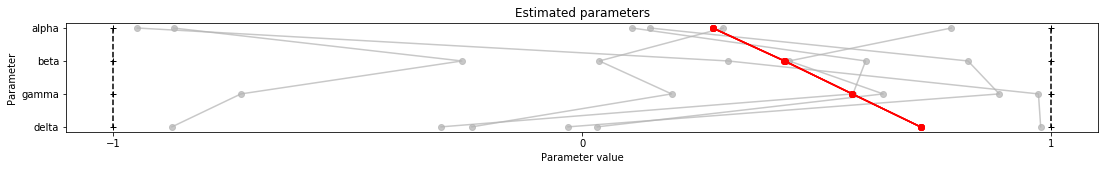

In [9]:
visualize.parameters(result)